# Digit recognizer - A simple problem using neural network with Keras 
### ** Nguyen Dang Minh, PhD **

* [**1. Introduction**](#ch1)
* [**2. Data preparation**](#ch2)
    * [2.1 Import and visualize the data](#ch2.1)
    * [2.2 Preprocess the data](#ch2.2)
    * [2.3 Data augmentation](#ch2.3)
* [**3. Model construction**](#ch3)
* [**4. Visualize the results**](#ch4)
    

<a id="ch1"></a>

## 1. Introduction

This is the my first deep learning project after I have completed [Andrew Ng 's deep learning specialization](https://www.coursera.org/specializations/deep-learning).

The goal of the project is from a handwritten digit, the computer can tell which number it is. The dataset is taken from [Kaggle's Digit Recognizer competition](https://www.kaggle.com/c/digit-recognizer). This is a supervised classification problem whereas the input is an array containing pixel-by-pixel values of 28 $\times$ 28 images, and the output is one of ten digit values (0-9). There can be multiple approach to this problem. One can consider **clustering** (images of the same digits will belong to the same cluster). However, we will not be able to take full advantage of the training data (the label). One can also use classical classification algorithm, such as [SVM](http://scikit-learn.org/stable/modules/svm.html) or [Random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Before learning neural network, I did try solving this problem using SVM (see code [here](https://github.com/dmnguyen92/MNIST/blob/master/svm.py)). The code takes about 1.5 hour to run and can achieve accuracy up to **97%**. Imagine your friend from Singapore writes you his 8-digit phone number (relatively short compared to, say, Germany, 10 numbers). The chance of making the right prediction is 0.97$^8 \approx$ 78%. This is not a very good result.

This time I will use a more powerful tool that is built to deal with images data: a convolutional neural network (conv-net). The code is written using **Keras** with Tensorflow backend. The reason I chose Keras for this project is because it is quite intuitive (compared to **Tensorflow**) and has lots of community support (compared to **PyTorch**). With a relatively small network (2 convolutional layer, 2 dense layer), the performance can reach **99.1%** within 140s.

<table class='image'>
<img src='MNIST.png' ></img>
<a id='fig1'><center> The MNIST dataset </center></a>
</table>

Here in Section 2 I will import, preprocess and augmented the data. The model is constructed in Section 3. The final section is for visualizing and analyzing the result. .


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import random
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from clr_callback import *
import time

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import gc

rcParams['font.size']=14
random.seed(1)

Using TensorFlow backend.


<a id="ch2"></a>

## 2. Data preparation

<a id="ch2.1"></a>

### 2.1 Import and visualize the data

In [2]:
dataset_orig = pd.read_csv('Data/train.csv')
select_idx = random.sample(range(0,len(dataset_orig)), 2200)
X_orig = dataset_orig.iloc[:,1:]
Y_orig = dataset_orig.iloc[:,0:1]

In [3]:
X_orig.shape

(42000, 784)

The independent variables have 42000 rows corresponding to 42000 training data. Each row is the pixel value (0-254) of a grayscale image with size of 28$\times$28 that has been flatten to a 1-d array

In [4]:
Y_orig.shape

(42000, 1)

Let us see if there is any data missing

In [5]:
X_orig.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
Y_orig.isnull().any().describe()

count         1
unique        1
top       False
freq          1
dtype: object

So there is no missing data. Next let's look at the data distribution

Text(0.5, 1.0, 'Training data disribution')

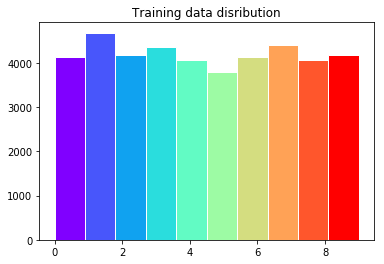

In [7]:
# This is to plot the data distribution
N, bins, patches = plt.hist(Y_orig.values, edgecolor='white')
colors = cm.rainbow(np.linspace(0, 1, len(patches)))
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])
plt.title('Training data disribution')

<a id="ch2.2"></a>

### 2.2 Preprocess the data

The first step is to reshape the independent variables back to its image form and normalize it, then perform one-hot encoding on the label data.

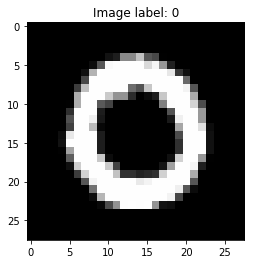

In [8]:
# Reshape and normalize
X_processed = X_orig.values.reshape(-1,28,28,1)
X_processed = X_processed/255.

# Show an example image
idx = 1
plt.imshow(X_processed[idx,:,:,0], cmap='gray')
plt.title('Image label: %i' %Y_orig.values[idx])

# One-hot encoding label data
Y_processed = to_categorical(Y_orig.values)

Next let's split the data into training and validation set. Here I use 90% for training and 10% for validation.

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_processed, Y_processed, test_size=0.1, random_state=1)

<a id="ch2.3"></a>

### 2.3 Data augmentation

One technique to improve the quality of the training set is to perform data augmentation, i.e. creating new input image by slightly rotate, shift or zoom-in the original one.

In [10]:
# Augment the data
train_datagen = ImageDataGenerator(rotation_range=15, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2)
train_datagen.fit(X_train)

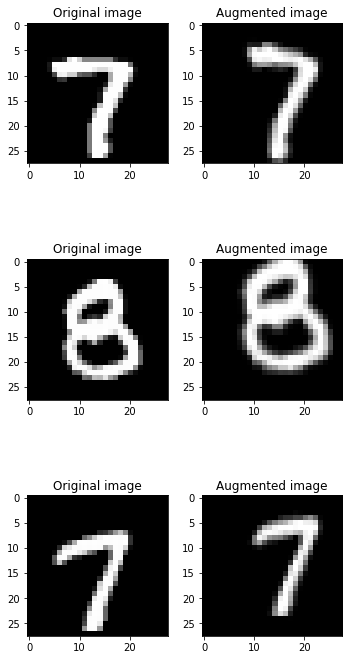

In [11]:
# Visualize the augmentation
fig = plt.figure(figsize=(5,10))
transform_list = random.sample(range(0,len(X_train)),3)
for i in range(3):
    idx = transform_list[i]
    ax = fig.add_subplot(3,2,i*2+1)
    plt.imshow(X_train[idx,:,:,0], cmap='gray')
    ax.set_title('Original image')
    
    ax = fig.add_subplot(3,2,i*2+2)
    plt.imshow(train_datagen.random_transform(X_train[idx,:,:,:])[:,:,0], cmap='gray')
    ax.set_title('Augmented image')
    
plt.tight_layout()

Here the images are augmented by rotating randomly within 15$^\circ$, shift vertically or horizontally up to 20% of the frame or zoom-in up to 20%.

<a id="ch3"></a>

## 3. Model construction

Here our model will consists of 2 convolutional layers to collect the graphical feature of the image, followed by 2 dense layer to do the classification job. 

In [12]:
def model_conv():
    model = Sequential()

    model.add(Conv2D(32,(5,5), padding='Same',activation='relu', input_shape=(28,28,1)))
    model.add(MaxPool2D(pool_size=(5,5)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64,(3,3), padding='Same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

The functionality of each layer:
* `Conv2D`: Run a convolutional windows throughout the image
* `Maxpool2D`: Within a certain window after convolution, pick the pixel with maximum value.  This step helps select important feature and reduce computational cost
* `Dropout`: A regularization layer to prevent overfitting
* `Flatten`: Flatten the result of the convolutional layer into 1-D array to serve as input for the `Dense` layer
* `Dense`: Fully connected neural network that performs the classification job

After building the model, the next step is to choose the criteria to fit the model into, and the corresponding optimization algorithm. Here we use `catergorical_crossentropy` as the lost function and `Adam` as the optimizer

In [13]:
model_demo = model_conv()
model_demo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
__________

Now is the time to train the model. We will perform **out-of-fold training**, then averaging the result. Each model will be trained with 30 epochs and batch size of 256. **Early stopping will be applied.**

In [14]:
# Model parameters
#clr = CyclicLR(base_lr=0.0005, max_lr=0.002, step_size=5., mode='triangular2')
epochs = 30
batch_size = 256
early_stopping = EarlyStopping(patience=5, verbose=1)
n_folds = 5

In [15]:
# Model list
splits = list(KFold(n_splits=n_folds, shuffle=True, random_state=2018).split(X_train, Y_train))
models = []
for i in range(n_folds):
    model_now = model_conv()
    models.append(model_now)

In [16]:
splits[0][0].shape

(30240,)

Epoch 1/30
118/118 [==============================] - 13s 111ms/step - loss: 1.2232 - acc: 0.5825 - val_loss: 0.2913 - val_acc: 0.9135
Epoch 2/30
118/118 [==============================] - 6s 54ms/step - loss: 0.4947 - acc: 0.8407 - val_loss: 0.1468 - val_acc: 0.9569
Epoch 3/30
118/118 [==============================] - 6s 54ms/step - loss: 0.3567 - acc: 0.8857 - val_loss: 0.1481 - val_acc: 0.9582
Epoch 4/30
118/118 [==============================] - 6s 55ms/step - loss: 0.3004 - acc: 0.9043 - val_loss: 0.1173 - val_acc: 0.9679
Epoch 5/30
118/118 [==============================] - 6s 53ms/step - loss: 0.2676 - acc: 0.9176 - val_loss: 0.1015 - val_acc: 0.9710
Epoch 6/30
118/118 [==============================] - 6s 53ms/step - loss: 0.2411 - acc: 0.9241 - val_loss: 0.1015 - val_acc: 0.9705
Epoch 7/30
118/118 [==============================] - 6s 53ms/step - loss: 0.2205 - acc: 0.9306 - val_loss: 0.0732 - val_acc: 0.9779
Epoch 8/30
118/118 [==============================] - 6s 52ms/step 

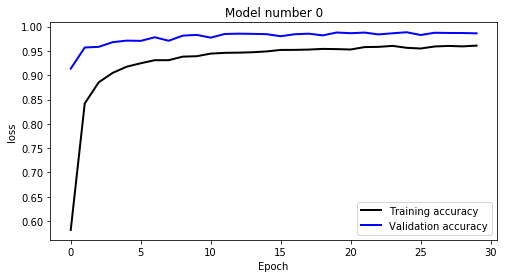

Epoch 1/30
118/118 [==============================] - 7s 58ms/step - loss: 1.3771 - acc: 0.5265 - val_loss: 0.2552 - val_acc: 0.9276
Epoch 2/30
118/118 [==============================] - 6s 53ms/step - loss: 0.5339 - acc: 0.8268 - val_loss: 0.1381 - val_acc: 0.9619
Epoch 3/30
118/118 [==============================] - 6s 51ms/step - loss: 0.3726 - acc: 0.8821 - val_loss: 0.1126 - val_acc: 0.9690
Epoch 4/30
118/118 [==============================] - 6s 52ms/step - loss: 0.3103 - acc: 0.9002 - val_loss: 0.2418 - val_acc: 0.9262
Epoch 5/30
118/118 [==============================] - 6s 54ms/step - loss: 0.2830 - acc: 0.9096 - val_loss: 0.0804 - val_acc: 0.9770
Epoch 6/30
118/118 [==============================] - 6s 54ms/step - loss: 0.2457 - acc: 0.9223 - val_loss: 0.0984 - val_acc: 0.9725
Epoch 7/30
118/118 [==============================] - 6s 54ms/step - loss: 0.2273 - acc: 0.9273 - val_loss: 0.1249 - val_acc: 0.9628
Epoch 8/30
118/118 [==============================] - 6s 53ms/step - 

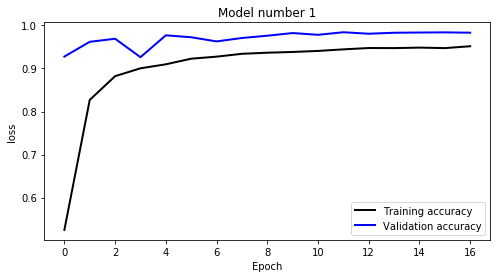

Epoch 1/30
118/118 [==============================] - 7s 56ms/step - loss: 1.2683 - acc: 0.5615 - val_loss: 0.3197 - val_acc: 0.9013
Epoch 2/30
118/118 [==============================] - 6s 54ms/step - loss: 0.5082 - acc: 0.8372 - val_loss: 0.1673 - val_acc: 0.9513
Epoch 3/30
118/118 [==============================] - 6s 51ms/step - loss: 0.3694 - acc: 0.8826 - val_loss: 0.1527 - val_acc: 0.9561
Epoch 4/30
118/118 [==============================] - 6s 52ms/step - loss: 0.3114 - acc: 0.9009 - val_loss: 0.1088 - val_acc: 0.9704
Epoch 5/30
118/118 [==============================] - 6s 53ms/step - loss: 0.2684 - acc: 0.9140 - val_loss: 0.1204 - val_acc: 0.9640
Epoch 6/30
118/118 [==============================] - 6s 53ms/step - loss: 0.2492 - acc: 0.9207 - val_loss: 0.1033 - val_acc: 0.9726
Epoch 7/30
118/118 [==============================] - 6s 52ms/step - loss: 0.2235 - acc: 0.9289 - val_loss: 0.0847 - val_acc: 0.9774
Epoch 8/30
118/118 [==============================] - 6s 53ms/step - 

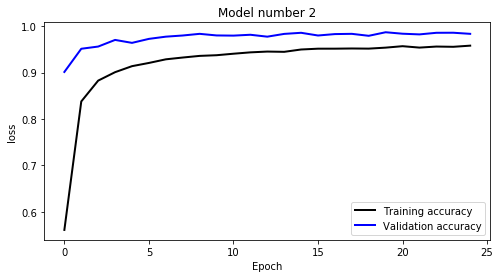

Epoch 1/30
118/118 [==============================] - 7s 55ms/step - loss: 1.2359 - acc: 0.5772 - val_loss: 0.2116 - val_acc: 0.9402
Epoch 2/30
118/118 [==============================] - 6s 53ms/step - loss: 0.4957 - acc: 0.8385 - val_loss: 0.1334 - val_acc: 0.9583
Epoch 3/30
118/118 [==============================] - 6s 52ms/step - loss: 0.3583 - acc: 0.8855 - val_loss: 0.1898 - val_acc: 0.9468
Epoch 4/30
118/118 [==============================] - 7s 57ms/step - loss: 0.2997 - acc: 0.9045 - val_loss: 0.1062 - val_acc: 0.9665
Epoch 5/30
118/118 [==============================] - 6s 53ms/step - loss: 0.2678 - acc: 0.9154 - val_loss: 0.1214 - val_acc: 0.9648
Epoch 6/30
118/118 [==============================] - 6s 52ms/step - loss: 0.2433 - acc: 0.9224 - val_loss: 0.1052 - val_acc: 0.9688
Epoch 7/30
118/118 [==============================] - 7s 58ms/step - loss: 0.2235 - acc: 0.9305 - val_loss: 0.0775 - val_acc: 0.9778
Epoch 8/30
118/118 [==============================] - 7s 57ms/step - 

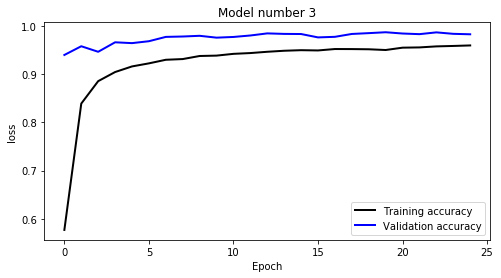

Epoch 1/30
118/118 [==============================] - 7s 62ms/step - loss: 1.2197 - acc: 0.5864 - val_loss: 0.2417 - val_acc: 0.9259
Epoch 2/30
118/118 [==============================] - 7s 57ms/step - loss: 0.4804 - acc: 0.8434 - val_loss: 0.1393 - val_acc: 0.9608
Epoch 3/30
118/118 [==============================] - 7s 55ms/step - loss: 0.3460 - acc: 0.8904 - val_loss: 0.1116 - val_acc: 0.9694
Epoch 4/30
118/118 [==============================] - 7s 56ms/step - loss: 0.2854 - acc: 0.9096 - val_loss: 0.1129 - val_acc: 0.9680
Epoch 5/30
118/118 [==============================] - 7s 56ms/step - loss: 0.2642 - acc: 0.9170 - val_loss: 0.0900 - val_acc: 0.9743
Epoch 6/30
118/118 [==============================] - 6s 55ms/step - loss: 0.2382 - acc: 0.9239 - val_loss: 0.0861 - val_acc: 0.9780
Epoch 7/30
118/118 [==============================] - 7s 56ms/step - loss: 0.2253 - acc: 0.9284 - val_loss: 0.1216 - val_acc: 0.9668
Epoch 8/30
118/118 [==============================] - 6s 55ms/step - 

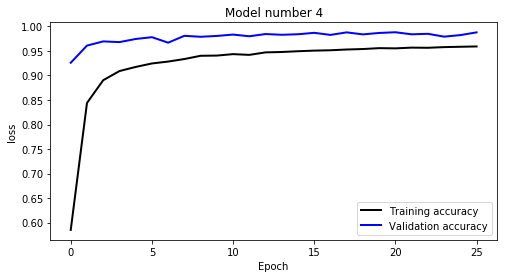

Total run time 789.700396 seconds


In [17]:
# Fitting
time_start = time.time()
for i in range(n_folds):
    X_train0 = X_train[splits[0][0]]
    Y_train0 = Y_train[splits[0][0]]
    X_val0 = X_train[splits[0][1]]
    Y_val0 = Y_train[splits[0][1]]
    hist = models[i].fit_generator(train_datagen.flow(X_train0, Y_train0, batch_size=batch_size),
                                      steps_per_epoch=int(len(X_train0)/batch_size), epochs=epochs,
                                      validation_data=(X_val0, Y_val0), callbacks=[early_stopping])
    
    fig = plt.figure(figsize=(8,4))
    plt.plot(hist.history['acc'], linewidth=2, color='black', label='Training accuracy')
    plt.plot(hist.history['val_acc'], linewidth=2, color='blue', label='Validation accuracy')
    plt.title('Model number %i' %i)
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()
    
time_end = time.time()
print('Total run time %f seconds' %(time_end-time_start))

In [18]:
gc.collect()

3765

<a id="ch4"></a>

## 4. Making prediction and visualize the results

The model takes approximately 12 minutes to run and achieve the accuracy of 99%. This number will slightly change depending on the random state you choose when splitting the change/test set. Now let's average all models for the final predictions

In [19]:
Y_pred = 0
for i in range(n_folds):
    Y_pred0 = models[i].predict(X_test)
    Y_pred = Y_pred+Y_pred0
    
Y_pred = Y_pred/n_folds
Y_pred = Y_pred[:,:].argmax(axis=1)
Y_test_orig = Y_test[:,:].argmax(axis=1)
score = accuracy_score(Y_test_orig, Y_pred)
print('Final accuracy score: %.4f' %score)

Final accuracy score: 0.9898


Now let us take a look at some example where the model gives the **wrong predictions**

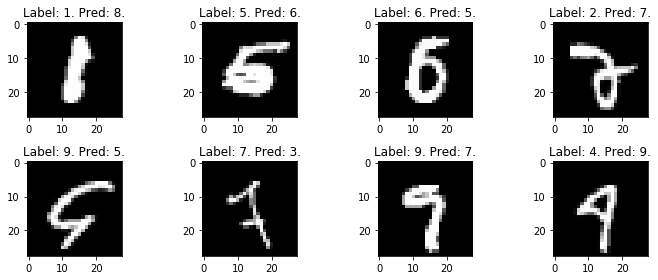

In [20]:
idx_error = np.where((Y_pred-Y_test_orig)!=0)

# Plot the error images
fig = plt.figure(figsize=(10,4))
for i in range(8):
    idx = idx_error[0][i]
    ax = fig.add_subplot(2,4,i+1)
    plt.imshow(X_test[idx,:,:,0], cmap='gray')
    ax.set_title('Label: %i. Pred: %i.' %(Y_test_orig[idx], Y_pred[idx]))
    
plt.tight_layout()

In many of these examples, the hand-writting is strongly distorted and it is difficult even for human to make the right prediction.